In [2]:
#NOTEBOOK DESCRIPTION

#  In this notebook I import a csv of the normalized data, and, using pre-defined ideal clustering parameters, run
#  Kmeans clustering and Gaussian mixtures modelling on the dataset
#  
#  Each ROI is assigned to a cluster and exported as a csv
#  Effect of each channel on the clustering is assessed using the ExtraTreesClassifier



import normalization as nrm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [3]:
#IMPORT CSV CONTAINING NORMALIZED DATA

norm_roi_df = pd.read_csv("BM_AM_180808_190401_norm.csv")
norm_roi_df.head(5)

,Unnamed: 0,image,total cell index,ind cell index,Area,Circ.,AR,Round,Solidity,% depth,...,z norm SCGN_median,z norm Kv2.2_median,z norm DAPI3_median,z norm CAVIII_median,z norm Rec_median,z norm DAPI4_median,z norm Calb_median,z norm PKC_median,z norm Parv_median,z norm DAPI5_median
0,0,21_s1m1,0,0,0.049,0.857,1.450,0.690,0.897,5.259663,...,-0.020591,0.302211,-0.746300,-0.565612,1.181044,-1.485921,-1.086136,-0.721506,-0.334144,-1.151339
1,1,21_s1m1,1,1,0.058,0.878,1.135,0.881,0.892,22.574779,...,2.700736,1.379877,0.631802,-0.585292,0.171825,-1.464316,-1.086136,-0.996451,-0.508083,-0.387308
2,2,21_s1m1,2,2,0.068,0.708,1.663,0.601,0.864,70.322646,...,-0.369889,0.786296,2.512683,-0.948704,-1.030963,-1.198727,-0.961293,-0.966496,-0.540182,1.400713
3,3,21_s1m1,3,3,0.067,0.763,1.336,0.749,0.863,54.642624,...,-0.155288,0.734430,1.223703,-0.391122,1.201069,-1.373327,-0.968633,-0.909795,-0.540182,0.586593
4,4,21_s1m1,4,4,0.099,0.799,1.435,0.697,0.887,17.882495,...,-0.280852,0.550017,0.442898,-0.593164,0.370732,-1.464316,-1.053046,-0.811371,-0.431165,-0.597813


In [5]:
#list current columns to figure out which you don't want
norm_roi_df.columns.values.tolist()


['Unnamed: 0',
 'image ',
 'total cell index',
 'ind cell index',
 'Area',
 'Circ.',
 'AR',
 'Round',
 'Solidity',
 '% depth',
 'Tarpg3_mean',
 'Islet1_mean',
 'Pax6_mean',
 'DAPI_mean',
 'CD15_mean',
 'GLT-1_mean',
 'Cav3.1_mean',
 'DAPI2_mean',
 'CABP5_mean',
 'SSCGN_mean',
 'Kv2.2_mean',
 'DAPI3_mean',
 'CAVIII_mean',
 'Rec_mean',
 'DAPI4_mean',
 'Calb_mean',
 'PKC_mean',
 'Parv_mean',
 'DAPI5_mean',
 'Tarpg3_stddev',
 'Islet1_stddev',
 'Pax6_stddev',
 'DAPI_stddev',
 'CD15_stddev',
 'GLT-1_stddev',
 'Cav3.1_stddev',
 'DAPI2_stddev',
 'CABP5_stddev',
 'SCGN_stddev',
 'Kv2.2_stddev',
 'DAPI3_stddev',
 'CAVIII_stddev',
 'Rec_stddev',
 'DAPI4_stddev',
 'Calb_stddev',
 'PKC_stddev',
 'Parv_stddev',
 'DAPI5_stddev',
 'Tarpg3_median',
 'Islet1_median',
 'Pax6_median',
 'DAPI_median',
 'CD15_median',
 'GLT-1_median',
 'Cav3.1_median',
 'DAPI2_median',
 'CABP5_median',
 'SCGN_median',
 'Kv2.2_median',
 'DAPI3_median',
 'CAVIII_median',
 'Rec_median',
 'DAPI4_median',
 'Calb_median',
 'PKC_m

In [6]:
#drop columns you don't want. Overrides roi_cluster_df

roi_cluster_df=norm_roi_df.copy() #creates new df
colNames=roi_cluster_df.columns[roi_cluster_df.columns.str.contains(pat='z norm')] #keeps only znorm data
roi_cluster_df=roi_cluster_df[colNames]
roi_cluster_df=roi_cluster_df.drop(['z norm total cell index', 'z norm ind cell index'], axis=1)

#drops specific channels you don't want
noanalysis = ['DAPI', 'Tarpg3', 'GLT-1', 'Cav3.1', 'Kv2.2', 'Area', 'Circ','AR','Round','Solidity','stddev', 'median']
for col in noanalysis:
    roi_cluster_df=roi_cluster_df.drop(roi_cluster_df.columns[roi_cluster_df.columns.str.contains(pat=col)], axis=1)

#saves data as an array to be used by tsne and umap
roi_cluster_array = roi_cluster_df.iloc[0:7973, 0:9].values

#prints updated df     
roi_cluster_df.head(5)

,z norm % depth,z norm Islet1_mean,z norm Pax6_mean,z norm CD15_mean,z norm CABP5_mean,z norm SSCGN_mean,z norm CAVIII_mean,z norm Rec_mean,z norm Calb_mean,z norm PKC_mean,z norm Parv_mean
0,-1.601558,-1.366725,-0.918895,-1.913062,-0.844291,0.056197,-0.693671,1.052548,-1.127992,-0.833182,-0.357527
1,-0.961800,-1.568243,-0.918895,-1.913062,-1.007763,2.341332,-0.550646,0.118356,-1.110838,-1.059369,-0.521227
2,0.802386,-1.310828,-0.531142,-1.534768,-0.716096,-0.359045,-1.023986,-1.036584,-1.034340,-1.086624,-0.600321
3,0.223041,-1.142732,-0.874030,-1.711355,-0.298764,0.055111,-0.416821,0.990765,-1.004723,-1.001020,-0.600321
4,-1.135170,-1.568243,-0.918895,-1.913062,-1.024985,0.370672,-0.539702,0.301466,-1.010498,-0.832594,-0.364061


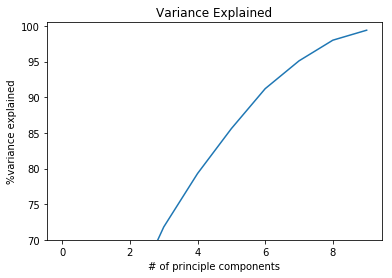

In [7]:
#RUN PCA

#calculate variance explained and cumulative variance explained
covar_matrix=PCA(n_components=10) #number must be equal or less than the # of channels
covar_matrix.fit(roi_cluster_df)
variance=covar_matrix.explained_variance_ratio_
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

#print graph of the variance explained with [n] features
plt.ylabel('%variance explained')
plt.xlabel('# of principle components')
plt.title('Variance Explained')
plt.ylim(70,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In [8]:
#Use PCA BEFORE feeding into tSNE
pca_num=PCA(n_components=7)
pca_array=pca_num.fit_transform(roi_cluster_df)
print ('Cumulative explained variance for 25 principal components:{}'.format(np.sum(pca_num.explained_variance_ratio_)))
pca_array

Cumulative explained variance for 25 principal components:0.9116058127306105


array([[-0.04359973, -1.21450603, -2.89817641, ...,  1.17630715,
         0.39623674, -0.41547623],
       [-0.57692599, -0.39854003, -2.99786163, ...,  2.44678012,
         0.41679374,  0.96237945],
       [-2.14455921, -1.08471913, -1.77786251, ...,  0.26683447,
        -0.06495048,  0.66546272],
       ...,
       [ 1.08734456, -0.67690464, -1.77098303, ...,  0.67779641,
         1.69223706, -1.784744  ],
       [-1.39702084, -0.9795042 , -0.28098619, ...,  0.81579121,
         1.251264  , -0.22019025],
       [ 0.95138131,  0.48202373,  0.29260713, ...,  0.85343258,
         1.05345284, -1.02032573]])

In [9]:
#RUN KMEANS
#assign the result to a new column in dataframe 'roi_cluterResults_df'


#pca_result_25_df=pd.DataFrame(pca_result_25)

kmeans = KMeans(n_clusters=8, random_state = 123)
kmeans.fit(pca_array)
print(kmeans.labels_)

roi_clusterResults_df=roi_cluster_df.copy()
a=kmeans.labels_
df_a=pd.DataFrame(a)
roi_clusterResults_df=pd.concat([roi_clusterResults_df, df_a], axis=1)
roi_clusterResults_df.head(5)

[1 6 2 ... 1 2 3]


,z norm % depth,z norm Islet1_mean,z norm Pax6_mean,z norm CD15_mean,z norm CABP5_mean,z norm SSCGN_mean,z norm CAVIII_mean,z norm Rec_mean,z norm Calb_mean,z norm PKC_mean,z norm Parv_mean,0
0,-1.601558,-1.366725,-0.918895,-1.913062,-0.844291,0.056197,-0.693671,1.052548,-1.127992,-0.833182,-0.357527,1
1,-0.961800,-1.568243,-0.918895,-1.913062,-1.007763,2.341332,-0.550646,0.118356,-1.110838,-1.059369,-0.521227,6
2,0.802386,-1.310828,-0.531142,-1.534768,-0.716096,-0.359045,-1.023986,-1.036584,-1.034340,-1.086624,-0.600321,2
3,0.223041,-1.142732,-0.874030,-1.711355,-0.298764,0.055111,-0.416821,0.990765,-1.004723,-1.001020,-0.600321,1
4,-1.135170,-1.568243,-0.918895,-1.913062,-1.024985,0.370672,-0.539702,0.301466,-1.010498,-0.832594,-0.364061,1


In [10]:
#RUNNING THE TSNE

n_sne = 7973 #with the code below, only runs the tsne on the first [n] number of values. Set equal to column length if you want the whole thing

tsne=TSNE(n_components=2, n_iter=1000, perplexity=40,random_state=123)

#runs tsne on a subset if n equals something else
rndperm=np.random.permutation(roi_cluster_df.shape[0])
#tsne_pca_results=tsne.fit_transform(pca_result_25[rndperm[:n_sne]]) 

#runs tsne on the original dataset
tsne_pca_results=tsne.fit_transform(roi_cluster_array)

print ('tSNE done')    

#plot tSNE
from ggplot import *
df_tsne = None
df_tsne = roi_cluster_df.loc[rndperm[:n_sne],:].copy()

df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot(df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE from PCA data (PCAs=25)")
chart

#regular plot of tsne
plt.title('tSNE from PCA data (PCAs=25)')
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1])


KeyboardInterrupt: 

In [ ]:
#ADD KMEANS TO TSNE
#kmeans = KMeans(n_clusters=8, random_state = 123)
#kmeans.fit(pca_array)
#print(kmeans.labels_)
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=kmeans.labels_)

Feature ranking:
1. feature 0 (0.189542)
2. feature 1 (0.161750)
3. feature 6 (0.118596)
4. feature 5 (0.112005)
5. feature 3 (0.080863)
6. feature 9 (0.080311)
7. feature 8 (0.075453)
8. feature 4 (0.070332)
9. feature 7 (0.058395)
10. feature 2 (0.052752)


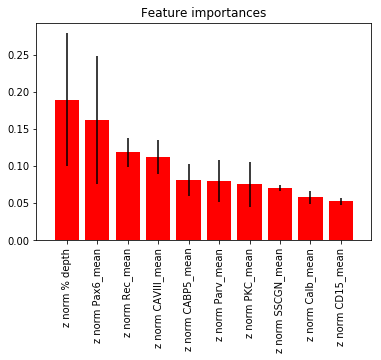

In [25]:
#CALCULATE FEATURE IMPORTANCES

channelNum=11

#turn dataframe into an array
array=roi_clusterResults_df.values
X=array[:,0:channelNum-1]
y=array[:,channelNum-1]
feat_labels=roi_clusterResults_df.columns.values

#build a forest and compute feature importances
forest=ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X, y)
importances=forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feat_labels=np.array(feat_labels)[indices]

#print feature ranking
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],width=0.8,
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()    

In [ ]:
# export Kmeans cluster assignments

#Gathering all of the data into CSV files, where each image dataset has a CSV for its k-Means labels and its GaussianMixture labels

updated_data = roi_df[["image "]]
from math import *

newest_data = updated_data.iloc[0:10672,].values
curr_pic = '[21_s1m1]'
curr_kmeans_array = []
curr_mixture_array = []

for i in range(0, pca_result_25.shape[0]):
    if newest_data[i] == '21_s1m1':
        curr_kmeans_array.append(kmeans.labels_[i])
        curr_mixture_array.append(gmm_labels[i])
    elif not pd.isnull(newest_data[i]):
        kmeans_csv = pd.DataFrame(np.array(curr_kmeans_array).reshape(len(curr_kmeans_array), 1), columns = ['Kmeans labels'])
        mixture_csv = pd.DataFrame(np.array(curr_mixture_array).reshape(len(curr_mixture_array), 1), columns = ['Mixture labels'])
        kmeans_file_name = str(curr_pic) + '_kmeans_labels.csv'
        mixture_file_name = str(curr_pic) + '_mixture_labels.csv'
        kmeans_csv.to_csv(kmeans_file_name)
        mixture_csv.to_csv(mixture_file_name)
        curr_pic = newest_data[i]
        curr_kmeans_array = []
        curr_mixture_array = []
    else:
        curr_kmeans_array.append(kmeans.labels_[i])
        curr_mixture_array.append(labels[i])


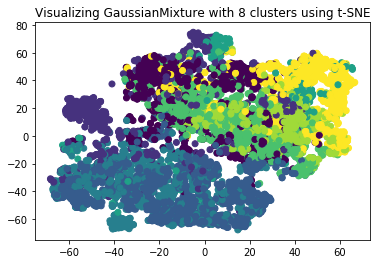

In [42]:
#Running GaussianMixture on PCA data

gmm = GaussianMixture(n_components=8).fit(pca_array)
gmm_labels = gmm.predict(pca_array)
#tsne = TSNE(n_components = 2, n_iter = 1000, perplexity = 30, random_state = 123)
#tsne_run = tsne.fit_transform(pca_array)

#Visualizing GaussianMixture with 8 clusters using t-SNE

plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=gmm_labels)

plt.title('Visualizing GaussianMixture with 8 clusters using t-SNE')
plt.show()

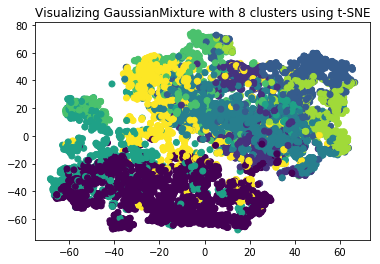

In [44]:
#VISUALIZING GMM ON RAW DATA

gmm = GaussianMixture(n_components=8).fit(roi_cluster_array)
gmm_labels = gmm.predict(roi_cluster_array)
#tsne = TSNE(n_components = 2, n_iter = 1000, perplexity = 30, random_state = 123)
#tsne_run = tsne.fit_transform(pca_array)

#Visualizing GaussianMixture with 8 clusters using t-SNE

plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=gmm_labels)

plt.title('Visualizing GaussianMixture with 8 clusters using t-SNE')
plt.show()

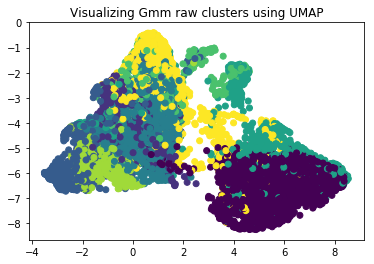

In [46]:
#VISUALIZING KMEANS AND GMM RESULTS USING UMAP

reducer = umap.UMAP(n_neighbors=200, random_state = 123)
umap_run = reducer.fit_transform(roi_cluster_array)
#my_dictionary = {}

#Visualizing K-Means with 8 clusters using UMAP

plt.scatter(umap_run[:,0],umap_run[:,1], c=gmm_labels)
plt.title('Visualizing Gmm raw clusters using UMAP')
plt.show()